In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import random
import cv2

import tensorflow as tf


In [2]:
seed = 42

os.listdir('/kaggle/input/')

['cassava-leaf-disease-classification', 'model-weights']

In [3]:
images_df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')#, dtype = str)
images_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
images_df = images_df.sample(frac = 1, random_state = seed)
images_df.head()

,image_id,label
9134,2615227158.jpg,4
1580,1277648239.jpg,3
7304,2305895487.jpg,3
13196,336299725.jpg,2
5333,1951270318.jpg,2


In [5]:
train_folder = '/kaggle/input/cassava-leaf-disease-classification/train_images/'
images_df['image path'] = train_folder + images_df['image_id']
images_df.head()

,image_id,label,image path
9134,2615227158.jpg,4,/kaggle/input/cassava-leaf-disease-classificat...
1580,1277648239.jpg,3,/kaggle/input/cassava-leaf-disease-classificat...
7304,2305895487.jpg,3,/kaggle/input/cassava-leaf-disease-classificat...
13196,336299725.jpg,2,/kaggle/input/cassava-leaf-disease-classificat...
5333,1951270318.jpg,2,/kaggle/input/cassava-leaf-disease-classificat...


In [6]:
print(len(images_df))

21397


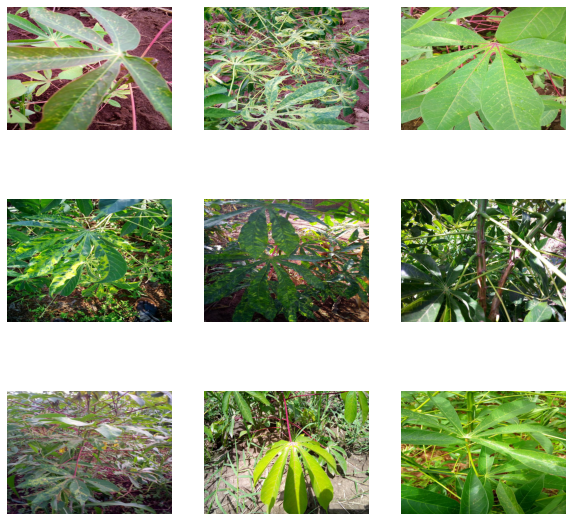

In [7]:
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(images_df.sample(9)['image path']):
    ax = plt.subplot(3, 3, i + 1)
    image = Image.open(image_path)
    plt.imshow(image)
    #plt.title(int(label))
    plt.axis("off")


In [8]:
train_val_split = 0.9
train_count = int(len(images_df) * train_val_split)
val_count = int(len(images_df) * (1 - train_val_split))
print(f'Number of training samples {train_count}')
print(f'Number of validation samples {val_count}')

Number of training samples 19257
Number of validation samples 2139


In [9]:
train_images_df = images_df[:train_count]
val_images_df = images_df[train_count:]

In [10]:
val_images_df.label.value_counts()#.plot(kind = 'bar')

3    1311
4     268
2     229
1     212
0     120
Name: label, dtype: int64

In [ ]:
train_images_df.label.value_counts()#.plot(kind = 'bar')

In [ ]:
train_images_df_minority = train_images_df[train_images_df['label'] != 3]

In [ ]:
train_images_df_minority.label.value_counts()

In [ ]:
train_images_df_minority_oversample = pd.concat([pd.concat([train_images_df[train_images_df['label']==0]]*1),
                                               pd.concat([train_images_df[train_images_df['label']==1]]*1),
                                               pd.concat([train_images_df[train_images_df['label']==2]]*1),
                                               pd.concat([train_images_df[train_images_df['label']==4]]*1)])
train_images_df_minority_oversample.label.value_counts()

In [ ]:
train_images_df_minority_oversample.tail()

In [ ]:
train_images_df_balanced = pd.concat([train_images_df, train_images_df_minority_oversample.sample(frac = 1, random_state = seed)])
train_images_df_balanced.label.value_counts().plot(kind='bar')
print(f'Balanced training set has {len(train_images_df_balanced)} images')

In [ ]:
train_images_df_balanced.tail()

In [11]:
batch_size = 8
image_size = 600
input_shape = (image_size, image_size, 3)
dropout_rate = 0.5
classes_to_predict = np.sort(train_images_df['label'].unique())
print(classes_to_predict)

[0 1 2 3 4]


In [12]:
#train_images_df.label.astype(int)
print(train_images_df.dtypes)

image_id      object
label          int64
image path    object
dtype: object


#Data augmentation with ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                              rotation_range = 40,
                                                              width_shift_range = 0.2,
                                                              height_shift_range = 0.2,
                                                              brightness_range = (0.6, 1.2),  
                                                              shear_range = 0.2,
                                                              zoom_range = 0.2,
                                                              horizontal_flip = True,
                                                              fill_mode = 'nearest')
train_generator = train_datagen.flow_from_dataframe(train_images_df,
                                                   directory = train_folder,
                                                   x_col = 'image_id',
                                                   y_col = 'label',
                                                   target_size = (image_size, image_size),
                                                   color_mode = 'rgb',
                                                   class_mode = 'sparse',
                                                   batch_size = batch_size)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_dataframe(val_images_df,
                                               directory = train_folder,
                                               x_col = 'image_id',
                                               y_col = 'label',
                                               target_size = (image_size, image_size),
                                               color_mode = 'rgb',
                                               class_mode = 'sparse',
                                               batch_size = batch_size)

In [13]:
#train_data = tf.data.Dataset.from_tensor_slices((train_images_df_balanced['image path'].values, train_images_df_balanced['label'].values))
train_data = tf.data.Dataset.from_tensor_slices((train_images_df['image path'].values, train_images_df['label'].values))
val_data = tf.data.Dataset.from_tensor_slices((val_images_df['image path'].values, val_images_df['label'].values))

In [14]:
autotune = tf.data.AUTOTUNE
print(autotune)

-1


In [15]:
def load_image_and_label_from_path(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    return image, label

train_data = train_data.map(load_image_and_label_from_path, num_parallel_calls = autotune)
val_data = val_data.map(load_image_and_label_from_path, num_parallel_calls = autotune)

In [16]:
train_data_batches = train_data.shuffle(buffer_size = 1000).batch(batch_size = batch_size).prefetch(buffer_size = autotune)
val_data_batches = val_data.batch(batch_size = batch_size).prefetch(buffer_size = autotune)
train_data_batches_for_eval = train_data.batch(batch_size = batch_size).prefetch(buffer_size = autotune)

In [ ]:
print(val_images_df.label.values)

In [ ]:
print(train_data_batches)

In [ ]:
def load_image_and_label_from_path_for_adapt(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image)
    #image = tf.keras.layers.experimental.preprocessing.RandomCrop(height = image_size, width = image_size)(image)
    image = tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size)(image)
    return image

adapt_data = tf.data.Dataset.from_tensor_slices(train_images_df['image path'].values)
adapt_data = adapt_data.map(load_image_and_label_from_path_for_adapt, num_parallel_calls = autotune)
adapt_data_batches = adapt_data.batch(batch_size = batch_size).prefetch(buffer_size = autotune)

In [18]:
augment_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomCrop(height = image_size, width = image_size),
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0.3)),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.5),
    #tf.keras.layers.experimental.preprocessing.RandomHeight(0.1, interpolation = 'nearest'),
    #tf.keras.layers.experimental.preprocessing.RandomWidth(0.1, interpolation = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.25)
], name = 'augmentation')

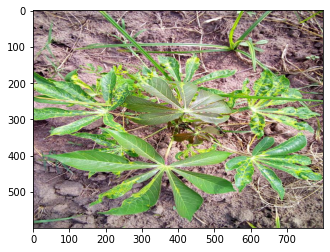

(800, 600)

In [19]:
preview = Image.open(images_df.iloc[1]['image path'])
plt.imshow(preview)
plt.show()
preview.size

In [ ]:
plt.figure(figsize=(10, 10))
image = tf.expand_dims(np.array(preview), 0)
print(image.shape)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augment_layers(image)
    plt.imshow(augmented_image[0])
    #plt.title(int(label))
    plt.axis("off")
print(augmented_image.shape)    

In [20]:
from tensorflow.keras.applications import EfficientNetB3
model = EfficientNetB3(weights = 'imagenet',
                       include_top = False,
                       drop_connect_rate = 0.5,
                       input_shape = input_shape)

43941888/43941136 [==============================] - 0s 0us/step


In [21]:
model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 600, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 600, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
model.trainable = False

In [22]:
def build_model(base_model):
    inputs = tf.keras.layers.Input(shape = input_shape, name = 'input')
    x = augment_layers(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name = 'gap')(x)
    x = tf.keras.layers.Dropout(dropout_rate, name = 'drop')(x)
    outputs = tf.keras.layers.Dense(len(classes_to_predict), activation = 'softmax', name = 'dense')(x)
    
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    
    return model

In [23]:
final_model = build_model(model)

In [ ]:
final_model.trainable = True

In [24]:
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 600, 600, 3)]     0         
_________________________________________________________________
augmentation (Sequential)    (None, 600, 600, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 19, 19, 1536)      10783535  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1536)              0         
_________________________________________________________________
drop (Dropout)               (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
____________________________________________

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight('balanced',
                                   classes = classes_to_predict,
                                   y = train_images_df.label.values)
print(class_weight)

In [25]:
epochs = 20
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                             patience = 3,
                                             verbose = 1),
             tf.keras.callbacks.ModelCheckpoint(filepath = 'best_model.h5',
                                                monitor='val_loss', 
                                                save_best_only=True,
                                                save_weights_only = True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.3,
                                                 patience=2,
                                                 mode = 'min',
                                                 verbose = 1)]
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

class_weights = {0 : 2,
                1 : 2,
                2 : 2,
                3 : 1,
                4 : 2}

final_model.compile(loss = loss_function,
                   optimizer = optimizer,
                   metrics = ['acc'])

In [ ]:
hist = final_model.fit(train_data_batches,
                      epochs = epochs,
                      validation_data = val_data_batches,
                      callbacks = callbacks,
                      class_weight = class_weights)

In [ ]:
final_model.save_weights('v3Checkpoint_val_loss_0p46.h5') 

In [26]:
final_model.load_weights("../input/model-weights/Checkpoint_val_loss_0p361.h5")

In [48]:
eval_before = final_model.evaluate(val_data_batches.take(3))

3/3 [==============================] - 18s 4s/step - loss: 0.5849 - acc: 0.8073


In [ ]:
eval_after = final_model.evaluate(val_data_batches)

In [ ]:
%%time
final_model.get_layer('efficientnetb3').get_layer('normalization').adapt(adapt_data_batches)

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

   
    


unfreeze_model(final_model)

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
train_predict = final_model.predict(train_data_batches_for_eval, verbose = 1)

In [ ]:
val_predict = final_model.predict(val_data_batches, verbose = 1)

In [ ]:
train_y = np.argmax(train_predict, axis=1)

In [ ]:
val_y = np.argmax(val_predict, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(train_images_df_balanced.label.values, train_y))

In [ ]:
print(classification_report(train_images_df_balanced.label.values, train_y))

In [ ]:
print(confusion_matrix(val_images_df.label.values, val_y))

In [ ]:
print(classification_report(val_images_df.label.values, val_y))

In [ ]:
print(confusion_matrix(train_images_df_balanced.label.values, train_y))

In [ ]:
print(classification_report(train_images_df_balanced.label.values, train_y))

In [ ]:
print(confusion_matrix(val_images_df.label.values, val_y))

In [ ]:
print(classification_report(val_images_df.label.values, val_y))

In [27]:
test_model = final_model

In [28]:
test_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 600, 600, 3)]     0         
_________________________________________________________________
augmentation (Sequential)    (None, 600, 600, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 19, 19, 1536)      10783535  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1536)              0         
_________________________________________________________________
drop (Dropout)               (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
____________________________________________

In [ ]:
test_model.evaluate(val_data_batches)

In [29]:
print([layer.name for layer in final_model.layers])

['input', 'augmentation', 'efficientnetb3', 'gap', 'drop', 'dense']


In [43]:
outputs = final_model.layers[-3].input
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 19, 19, 1536), dtype=tf.float32, name=None), name='efficientnetb3/top_activation/IdentityN:0', description="created by layer 'efficientnetb3'")


In [ ]:
def build_vis_model(model):
    inputs = tf.keras.layers.Input(shape = (600, 800, 3))
    x = tf.keras.layers.



In [30]:
vis_model = tf.keras.Model(inputs = final_model.input, outputs = final_model.layers[-3].input)

In [31]:
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])
print(layer_names)

NameError: name 'outputs' is not defined

In [105]:
def get_CAM(processed_image, actual_label, layer_name):
    model_grad = tf.keras.Model(inputs = final_model.input, 
                       outputs = [final_model.layers[-3].input, final_model.output])
   
    
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        # watch the conv_output_values
        tape.watch(conv_output_values)

        ## Use binary cross entropy loss
        ## actual_label is 0 if cat, 1 if dog
        # get prediction probability of dog
        # If model does well, 
        # pred_prob should be close to 0 if cat, close to 1 if dog
        pred_prob = predictions
        
        # make sure actual_label is a float, like the rest of the loss calculation
        #actual_label = tf.cast(actual_label, dtype=tf.float32)
        
        # add a tiny value to avoid log of 0
        smoothing = 0.00001 
        
        # Calculate loss as binary cross entropy
        #loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
        print(actual_label)
        print(pred_prob)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(actual_label, pred_prob).numpy()
        print(f"binary loss: {loss}")
    
    # get the gradient of the loss with respect to the outputs of the last conv layer
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = tf.keras.backend.mean(grads_values, axis=(0,1,2))
    
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()
    
    # weight the convolution outputs with the computed gradients
    for i in range(512): 
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap

In [106]:
def show_sample(idx=None):
    
    # if image index is specified, get that image
    if idx:
        for img, label in val_data_batches.take(idx):
            sample_image = img[0]
            sample_label = label[0]
    # otherwise if idx is not specified, get a random image
    else:
        for img, label in val_data_batches.shuffle(1000).take(1):
            sample_image = img[0]
            sample_label = label[0]
            
    sample_image_cropped = tf.image.random_crop(sample_image, input_shape)
    sample_image_processed = np.expand_dims(sample_image_cropped, axis=0)
    
    
    
    activations = vis_model.predict(sample_image_processed)
    print(activations.shape)
    pred_label = np.argmax(final_model.predict(sample_image_processed), axis=-1)[0]
    
    sample_activation = activations[0,:,:,16]
    
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    heatmap = get_CAM(sample_image_processed, sample_label, layer_name = 'efficientnetb3')
    heatmap = cv2.resize(heatmap, (sample_image_cropped.shape[0], sample_image_cropped.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    converted_img = sample_image_cropped.numpy()
    print(converted_img.dtype)
    print(heatmap.dtype)
    super_imposed_image = cv2.addWeighted(converted_img.astype('float32'), 0.2, heatmap.astype('float32'), 2e-3, 0.0)

    f,ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.tight_layout()
    plt.show()
  
    return activations

In [107]:
activations = show_sample(idx=1)

(1, 19, 19, 1536)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor([[5.1985962e-06 1.1966541e-05 1.0897291e-05 9.9954033e-01 4.3162412e-04]], shape=(1, 5), dtype=float32)
binary loss: 0.00045980370487086475


AttributeError: 'numpy.float32' object has no attribute '_id'

In [68]:
for img, label in val_data_batches.take(1):
            test_img = img[0]
            test_sample_label = label[0]

print(type(test_img))
print(test_img.shape)
test_img = np.expand_dims(tf.image.random_crop(test_img, input_shape), axis=0)
result = vis_model(test_img)
print(result.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(600, 800, 3)
(1, 19, 19, 1536)


In [1]:
print('test')

test
